# Popularity Model

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('books/Ratings.csv')
df1.columns = ['uid', 'bid', 'rating']
df1.head(3)

,uid,bid,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [3]:
df2 = pd.read_csv('books/GoodReadBooks.csv', error_bad_lines=False)
df2.head(3)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic


In [4]:
df = df1.merge(df2, left_on='bid', right_on='isbn')
df = df.dropna()
df = df.drop_duplicates(subset='isbn')
df.head(3)

,uid,bid,rating,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,276747,0679776818,8,6259,Birdsong,Sebastian Faulks,4.09,0679776818,9780679776819,eng,483,57513,2306,6/2/1997,Vintage International
47,276798,3548603203,6,45449,Artemis Fowl (Artemis Fowl #1),Eoin Colfer/Claudia Feldmann,3.84,3548603203,9783548603209,ger,240,428,24,5/1/2003,List
71,276808,0395547032,10,12570,A Confederate General from Big Sur / Dreaming ...,Richard Brautigan,4.25,0395547032,9780395547038,en-US,608,1724,103,2/4/1991,Mariner Books


In [5]:
train, test = train_test_split(df, test_size=0.20, random_state=42)

In [6]:
def rmse(y,h):
    """RMSE
    Args:
        y: real y
        h: predicted y
    Returns:
        RMSE
    """
    a = y-h

    return np.sqrt(sum(a**2)/len(a))

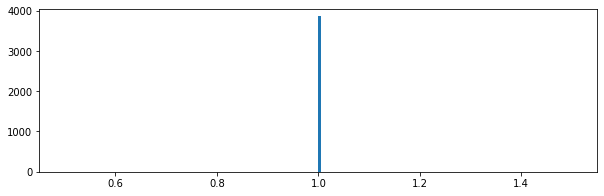

In [7]:
# Distribution of the # of Ratings per Book
facet, axes = plt.subplots(1, 1, figsize=(10, 3))
n, bins, patches = plt.hist(df['bid'].value_counts(), 200) #, log = True)   
#plt.title('Distribution of # of reviews per Book in Dataset (mean = 597 reviews / max = 22806 / min = 8 )')
plt.show()

In [8]:
## DEFINING THE TAIL
tailcomp = df.groupby(by= 'bid', as_index=False).agg({'rating':pd.Series.count}).sort_values(by = 'rating', ascending = False)
tot = sum(tailcomp['rating'])
tailcomp['popshare']= [x/tot for x in tailcomp['rating']]
tailcomp['popshare']= tailcomp['popshare'].cumsum()
tailcomp['category']= ['Head' if x<0.95 else 'Tail' for x in tailcomp['popshare']]

#finalbooks.loc[finalbooks.popshare >= 0.8].describe()
tail = tailcomp.loc[tailcomp.popshare >= 0.95]
tail

,bid,rating,popshare,category
1340,0385014805,1,0.950156,Tail
1341,0385017332,1,0.950415,Tail
1342,0385023510,1,0.950675,Tail
1343,0385040202,1,0.950935,Tail
1344,0385074077,1,0.951194,Tail
...,...,...,...,...
1288,0380707632,1,0.998962,Tail
1289,038071082X,1,0.999221,Tail
1290,0380710846,1,0.999481,Tail
1291,0380711966,1,0.999740,Tail


In [9]:
## BASELINE APPROACH: POPULARITY MODEL

popular = df.groupby('bid')['ratings_count','average_rating'].sum().sort_values(by = 'ratings_count',ascending=False).reset_index()
popular.head(3)

<ipython-input-9-37da2d43f109>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  popular = df.groupby('bid')['ratings_count','average_rating'].sum().sort_values(by = 'ratings_count',ascending=False).reset_index()


,bid,ratings_count,average_rating
0,0618260307,2530894,4.27
1,0316769177,2457092,3.80
2,043965548X,2339585,4.56


In [10]:
poprank = test.merge(popular, on=['bid','ratings_count','average_rating'])
poprank['pred']= np.round(poprank['average_rating'])
poprank['ratingYN']= [1 if x>= 4 else 0 for x in poprank['rating']]


poprank = poprank.sort_values(by=['uid', 'ratings_count'], ascending=False)
poprank.head(3)

,uid,bid,rating,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,pred,ratingYN
26,278777,1583225366,5,12615,Media Control: The Spectacular Achievements of...,Noam Chomsky,4.02,1583225366,9781583225363,eng,103,4332,320,9/3/2002,Seven Stories Press,4.0,1
201,278771,0812524268,0,7968,Red Prophet (Tales of Alvin Maker #2),Orson Scott Card,3.79,0812524268,9780812524260,en-US,311,18228,427,7/15/1992,Tor Fantasy,4.0,0
250,278586,0553575090,8,31366,Deception on His Mind (Inspector Lynley #9),Elizabeth George,4.05,0553575090,9780553575095,eng,716,8028,289,10/6/1998,Bantam Books,4.0,1


In [11]:
poplista = []

for i in range(15000):
  a = poprank.loc[poprank['uid'] == i+1]['rating'].tolist()
  poplista.append(a)
  if (i+1)%1000 == 0: print(f'done: {i+1}')

done: 1000
done: 2000
done: 3000
done: 4000
done: 5000
done: 6000
done: 7000
done: 8000
done: 9000
done: 10000
done: 11000
done: 12000
done: 13000
done: 14000
done: 15000


In [12]:
top = poprank.sort_values('ratings_count',ascending = False).groupby('uid').head(10)
top

,uid,bid,rating,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,pred,ratingYN
689,882,0618260307,10,5907,The Hobbit or There and Back Again,J.R.R. Tolkien,4.27,0618260307,9780618260300,eng,366,2530894,32871,8/15/2002,Houghton Mifflin,4.0,1
678,2793,0439358078,0,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,4.0,0
723,11676,0618346252,0,34,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. Tolkien,4.36,0618346252,9780618346257,eng,398,2128944,13670,9/5/2003,Houghton Mifflin Harcourt,4.0,0
166,4599,0142000671,10,890,Of Mice and Men,John Steinbeck,3.87,0142000671,9780142000670,eng,103,1755253,25554,1/8/2002,Penguin Books,4.0,1
290,55492,0064410935,8,24178,Charlotte's Web,E.B. White/Garth Williams/Rosemary Wells,4.17,0064410935,9780064410939,eng,184,1300470,14739,10/1/2001,HarperCollinsPublishers,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,217121,051712310X,0,41073,Children of the Thunder / The Tides of Time / ...,John Brunner,2.92,051712310X,9780517123102,eng,800,11,1,5/3/1995,Wings,3.0,0
346,127233,0140326928,0,42311,Astrid Lindgren: Storyteller to the World,Johanna Hurwitz/Michael Dooling,3.69,0140326928,9780140326925,eng,64,10,2,11/1/1991,Puffin,4.0,0
114,120695,1562920588,0,38609,Don't Wait for Your Ship to Come In... Swim Ou...,John Mason,3.22,1562920588,9781562920586,eng,160,9,2,12/1/1994,Honor Books,3.0,0
482,26443,2914370318,10,34948,L'epée de Shannara,Terry Brooks/Rosalie Guillaume,3.45,2914370318,9782914370318,fre,390,6,2,11/27/2002,Bragelonne,3.0,1


In [13]:
print('Popularity Model RMSE: ', round(rmse(poprank['rating'],poprank['average_rating']), 3))

Popularity Model RMSE:  4.112
